## Selecting Models

In [11]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import joblib

# Loading the data
data = pd.read_csv('loan_prediction.csv')

# Encoding the target variable
data['Loan_Status'] = data['Loan_Status'].map({'Y': 1, 'N': 0})

# Creating a new feature for total income
data['TotalIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']

# Dropping the 'Loan_ID' column and splitting the data into features and target variable
X = data.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = data['Loan_Status']

# Defining the categorical and numerical columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Filling missing values
for col in num_cols:
    X[col].fillna(X[col].mean(), inplace=True)

for col in cat_cols:
    X[col].fillna(X[col].mode()[0], inplace=True)

# Creating preprocessing pipelines for different scalers
num_pipelines = []
for scaler in [StandardScaler(), MinMaxScaler(), RobustScaler()]:
    num_pipelines.append(
        Pipeline([
            ('scaler', scaler)
        ])
    )

cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder())
])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Defining the models and hyperparameters to tune
models = [
    ("Logistic Regression", LogisticRegression(), {'model__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}),
    ("Decision Tree", DecisionTreeClassifier(), {'model__max_depth': [None, 5, 10, 15, 20, 30, 50], 'model__min_samples_split': [2, 3, 4, 5, 10], 'model__min_samples_leaf': [1, 2, 3, 4, 5]}),
    ("Support Vector Machine", SVC(), {'model__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'model__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'model__max_depth': [3, 5, 7, 10], 'model__learning_rate': [0.01, 0.1, 0.2, 0.3], 'model__n_estimators': [50, 100, 150, 200]})
]

# Training, tuning, and evaluating each model with each scaler
for num_pipeline in num_pipelines:
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])

    for name, model, params in models:
        full_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        grid_search = GridSearchCV(full_pipeline, param_grid=params, cv=5)
        grid_search.fit(X_train, y_train)

        print(f"Best parameters for {name} with {type(num_pipeline.named_steps['scaler']).__name__}: {grid_search.best_params_}")
        print(f"Best score for {name} with {type(num_pipeline.named_steps['scaler']).__name__}: {grid_search.best_score_}")

        predictions = grid_search.predict(X_test)

        print(f"{name} Accuracy: {accuracy_score(y_test, predictions)}\n")


Best parameters for Logistic Regression with StandardScaler: {'model__C': 0.01}
Best score for Logistic Regression with StandardScaler: 0.7983714698000413
Logistic Regression Accuracy: 0.8536585365853658

Best parameters for Decision Tree with StandardScaler: {'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 3}
Best score for Decision Tree with StandardScaler: 0.771902700474129
Decision Tree Accuracy: 0.8536585365853658

Best parameters for Support Vector Machine with StandardScaler: {'model__C': 10, 'model__gamma': 0.01}
Best score for Support Vector Machine with StandardScaler: 0.8004122861265717
Support Vector Machine Accuracy: 0.8536585365853658

Best parameters for XGBoost with StandardScaler: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 150}
Best score for XGBoost with StandardScaler: 0.7983714698000413
XGBoost Accuracy: 0.8536585365853658

Best parameters for Logistic Regression with MinMaxScaler: {'model__C': 1.0}


## Selected model Logistic Regression

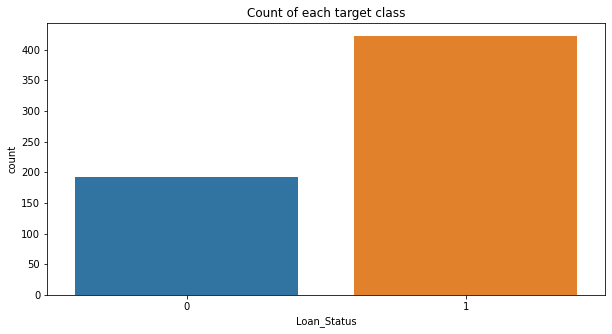

Best parameters for Logistic Regression: {'model__C': 0.001, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best score for Logistic Regression: 0.7437037037037036
Logistic Regression Accuracy: 0.7751479289940828
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73        85
           1       0.71      0.94      0.81        84

    accuracy                           0.78       169
   macro avg       0.81      0.78      0.77       169
weighted avg       0.81      0.78      0.77       169



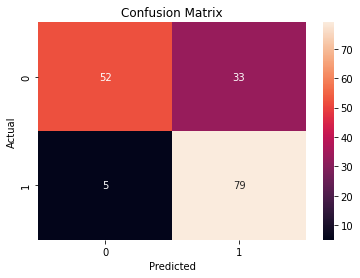

['best_model.pkl']

In [31]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.utils import resample
import joblib

# Loading the data
data = pd.read_csv('loan_prediction.csv')

# Encoding the target variable
data['Loan_Status'] = data['Loan_Status'].map({'Y': 1, 'N': 0})

# Creating a new feature for total income
data['TotalIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']

# Dropping the 'Loan_ID' column and splitting the data into features and target variable
X = data.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = data['Loan_Status']

# Defining the categorical and numerical columns
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Creating preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', IterativeImputer(estimator=BayesianRidge())),
    ('scaler', RobustScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Checking the imbalance in the target variable
plt.figure(figsize=(10,5))
sns.countplot(y)
plt.title("Count of each target class")
plt.show()

# Handling the imbalance in the target variable using sklearn's resample
X = pd.concat([X, y], axis=1)

# Separate majority and minority classes
df_majority = X[X.Loan_Status==1]
df_minority = X[X.Loan_Status==0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.Loan_Status.value_counts()

y = df_upsampled.Loan_Status
X = df_upsampled.drop('Loan_Status', axis=1)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the model and hyperparameters to tune
#model = LogisticRegression(class_weight={0:0.52, 1:0.48})
model = LogisticRegression()
params = {'model__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'model__penalty': ['l1', 'l2', 'elasticnet'], 'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


# Creating the pipeline
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(full_pipeline, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")
print(f"Best score for Logistic Regression: {grid_search.best_score_}")

# Making predictions on the test set
predictions = grid_search.predict(X_test)

# Evaluating the model
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, predictions)}")
print("Classification Report:")
print(classification_report(y_test, predictions))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Saving the best model to a file
joblib.dump(grid_search.best_estimator_, 'best_model.pkl')

## Deployment

In [32]:
# Function for loan prediction
def predict_loan_status(model, input_data):
    # Convert input data into a pandas DataFrame (this assumes input_data is a dictionary)
    df = pd.DataFrame(input_data, index=[0])

    # Preprocess the input data
    df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    for col in num_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Make prediction
    prediction = model.predict(df)

    # Return the prediction
    return "Eligible for loan" if prediction[0] == 1 else "Not eligible for loan"


In [35]:
def get_user_input():
    # Define the input data for a new prediction
    new_data = {
        'Gender': input('Enter Gender (Male/Female): '),
        'Married': input('Enter Married (Yes/No): '),
        'Dependents': input('Enter Dependents (0/1/2/3+): '),
        'Education': input('Enter Education (Graduate/Not Graduate): '),
        'Self_Employed': input('Enter Self_Employed (Yes/No): '),
        'ApplicantIncome': int(input('Enter ApplicantIncome: ')),
        'CoapplicantIncome': int(input('Enter CoapplicantIncome: ')),
        'LoanAmount': float(input('Enter LoanAmount: ')),
        'Loan_Amount_Term': float(input('Enter Loan_Amount_Term: ')),
        'Credit_History': float(input('Enter Credit_History (1.0 for yes, 0.0 for no): ')),
        'Property_Area': input('Enter Property_Area (Urban/Semiurban/Rural): ')
    }
    return new_data

# Load the best model (replace with the actual path to your model file)
best_model = joblib.load('best_model.pkl')

# Get user input
new_data = get_user_input()

# Make a prediction with the model
print(predict_loan_status(best_model, new_data))


Enter Gender (Male/Female):  Female
Enter Married (Yes/No):  No
Enter Dependents (0/1/2/3+):  2
Enter Education (Graduate/Not Graduate):  Graduate
Enter Self_Employed (Yes/No):  No
Enter ApplicantIncome:  30000
Enter CoapplicantIncome:  45000
Enter LoanAmount:  60000
Enter Loan_Amount_Term:  4
Enter Credit_History (1.0 for yes, 0.0 for no):  0.0
Enter Property_Area (Urban/Semiurban/Rural):  Urban


Not eligible for loan
